## GDP Prediction

### Data Processing

import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tushare as ts
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [2]:
ygdp=pd.read_csv('./YGDP.csv')
ygdp['DATE'] = pd.to_datetime(ygdp['DATE'])
ygdp.reset_index(drop=True, inplace=True)
ygdp.set_index('DATE', inplace=True)
ygdp['year'] = ygdp.index.year
ygdp.set_index('year', inplace=True)
fygdp=ygdp['FYGDP'] # series

In [3]:
train = fygdp[:-20].copy()
val = fygdp[-40:-20].copy()
test = fygdp[-20:].copy()

### Stablized data

1. define unit root function

After obtaining the time series data, there are two main methods for stationarity test: the naked eye test and the unit root test.

The advantage of the naked eye is simple and easy, but the disadvantage is that it is not accurate and not universal. Visual inspection mainly looks at sequence diagrams, ACF, and PACF.

The ARMA formula is actually a stochastic difference equation. The sequence should be stable, and the solution of the equation should be in the unit circle, or the characteristic root of the corresponding inverse characteristic equation should be outside the unit circle.

According to the general characteristics of time series, the solution of the equation is unlikely to fall outside the unit element. Because if it is outside the unit circle, it means that the impact of historical data becomes greater with time. In reality, there is basically no such situation. Therefore, if it is not on the circle, it is inside the circle, and only needs to check whether it falls on the unit circle. This is the unit root test.

Falling on the unit circle is the unit root, and the sequence is not stationary (H0); otherwise, the sequence is stationary. The unit root test is usually done by Augmented Dickey-Fuller test, and this method is also used in this example. In addition, the lower function also plots the mean and variance of the sliding.

In [4]:
def test_stationarity(timeseries):
    
    #moving average and variance
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    # plot statistic variable
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

2. check the original series

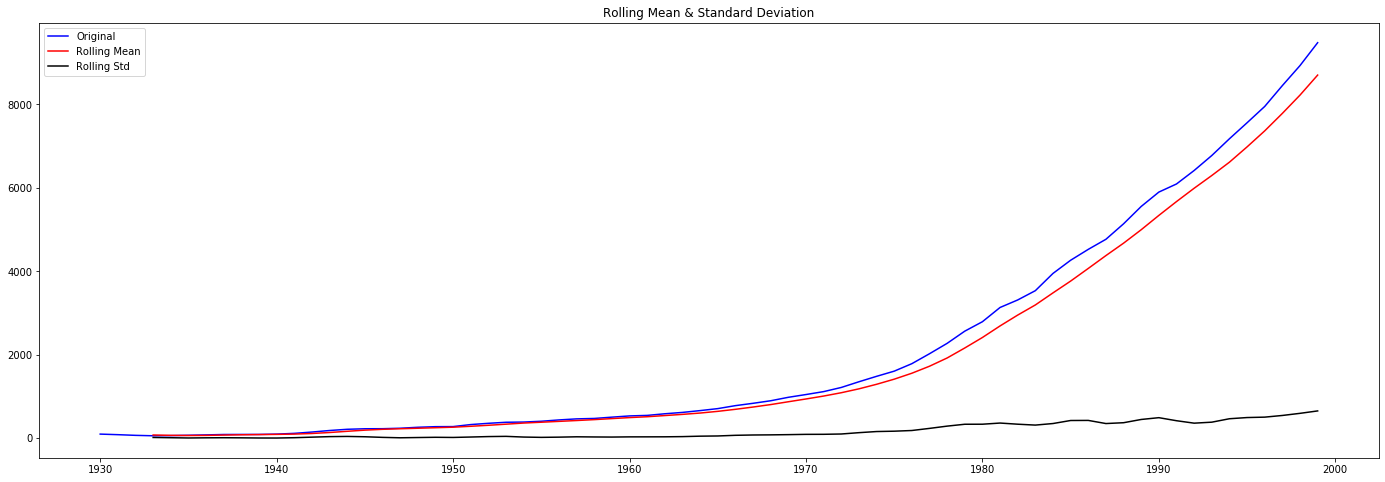

Results of Dickey-Fuller Test:
Test Statistic                  1.514188
p-value                         0.997576
#Lags Used                      6.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [5]:
test_stationarity(train)

p_value is higher than 0.05, cannot refuse H0

3. log_gdp

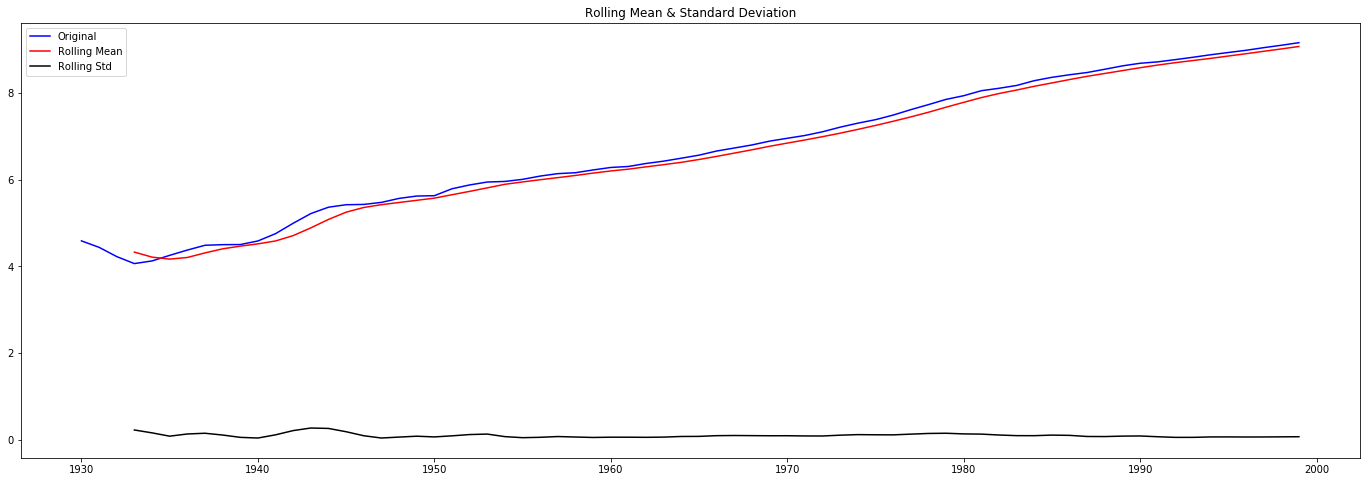

Results of Dickey-Fuller Test:
Test Statistic                 -0.711051
p-value                         0.843866
#Lags Used                      1.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [6]:
log_gdp_train = np.log(train)
test_stationarity(log_gdp_train)

still cannot refuse H0

4. first difference

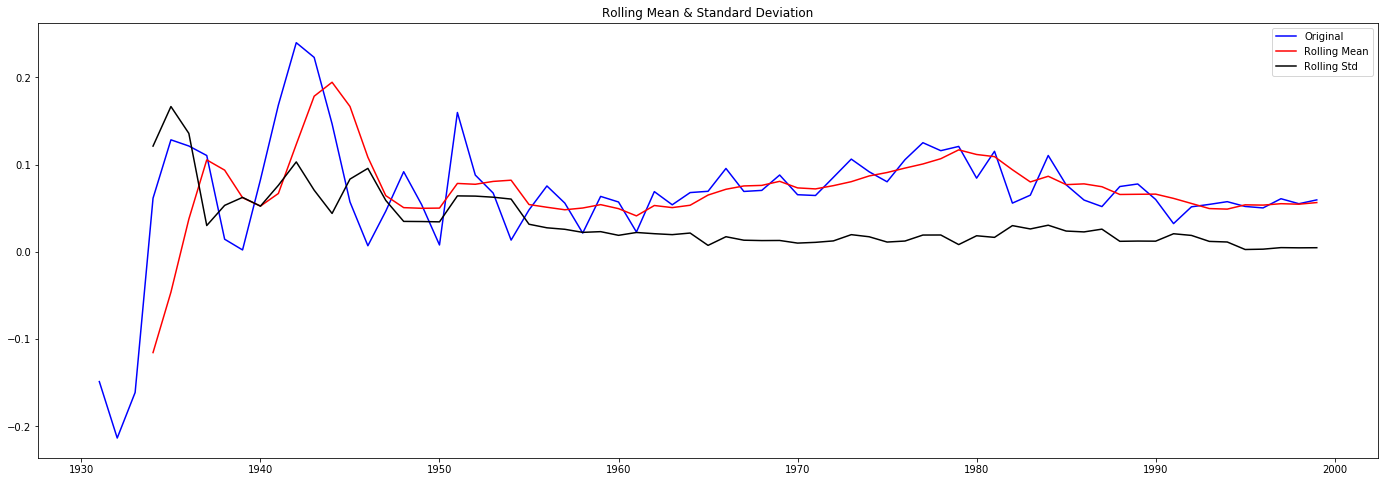

Results of Dickey-Fuller Test:
Test Statistic                 -4.339589
p-value                         0.000379
#Lags Used                      0.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [7]:
log1_gdp_train=log_gdp_train.diff(1)
log1_gdp_train.dropna(inplace=True)
test_stationarity(log1_gdp_train)

The p-value is small enough (less than 0.05), so we can reject the null hypothesis and think that the series is stationary.

In [8]:
log1_gdp_train.index

Int64Index([1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
            1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
            1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
            1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
            1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
            1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
            1997, 1998, 1999],
           dtype='int64', name='year')

### Model and simulation

1. set diff

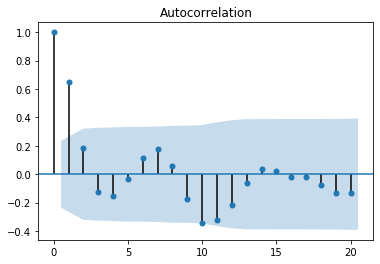

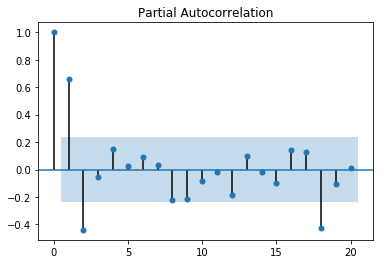

In [9]:
plot_acf(log1_gdp_train,lags=20)
plot_pacf(log1_gdp_train,lags=20)
plt.show()

Automatical ordering finds the smallest value of aic, bic, hqic by traversing the possible orders, as the optimal order. It can be achieved by the following statement:

In [10]:
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(log1_gdp_train,max_ar=3,max_ma=3,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

/Users/tamsin/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 0)

2. train

In [11]:
MODEL20=ARMA(log1_gdp_train,(2,0)).fit()

/Users/tamsin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Residual and white noise

If the residual is a white noise sequence, it means that the useful information in the time sequence has been extracted, and the rest are all random disturbances, which cannot be predicted and used.

If the residual sequence passes the white noise test, the modeling can be terminated because there is no information to continue extracting. If the residual fails the white noise test, it means that there is still useful information in the residual, and the model needs to be modified or further extracted

1. qq plot of white noise

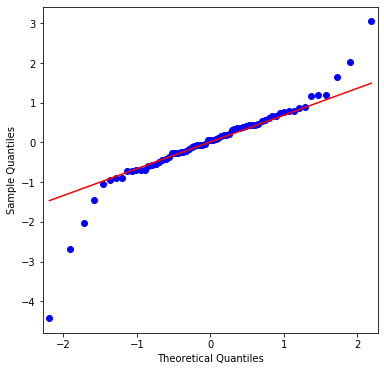

In [12]:
resid = MODEL20.resid
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

It can be seen from the qq graph that the residual sequence can be considered as a normal distribution.

2. correlation of RE

This example uses the Durbin-Watson test (D-W test) commonly used to test autocorrelation. The inspection shows that DW=1.61, which is close to 2, so it can be considered that there is no first-order correlation in the sequence.

In [13]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

1.6818953071770464


You can grind from the two steps above, and the residual sequence is normally distributed and independent of each other. Therefore, it can be regarded as Gaussian white noise, and the modeling can be terminated by the white noise test.

## Prediction

1. predict series after stationary

The index can only be processed manually.


In [14]:
PREDICT_ARMA = MODEL20.predict(start=1,end=69)
PREDICT_ARMA.index=PREDICT_ARMA.index+1930

/Users/tamsin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


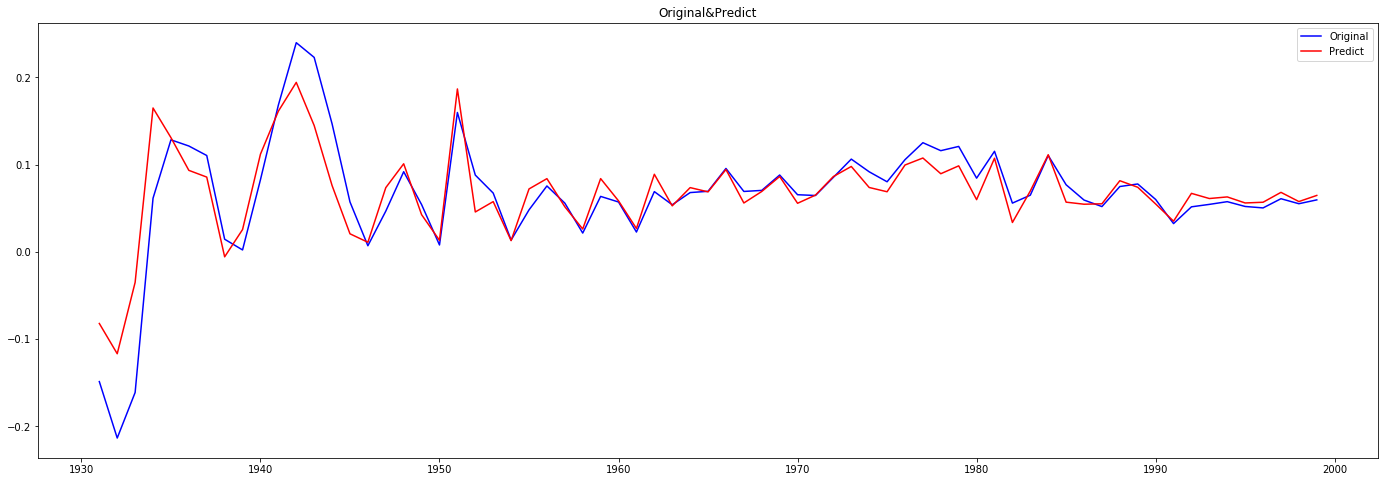

In [16]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(log1_gdp_train, color='blue',label='Original')
predict = plt.plot(PREDICT_ARMA, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

2. predict original series

In [20]:
# back before first diff
PREDICT_GDP_LOG = PREDICT_ARMA.add(log_gdp_train.shift(1))
#PREDICT_GDP_LOG[2000]=PREDICT_ARMA[2000]+log_gdp_train[1999]
# back before log
PREDICT_GDP = np.exp(PREDICT_GDP_LOG)
PREDICT_GDP.dropna(inplace=True)
PREDICT_GDP.tail(5)

1995    7590.781340
1996    8003.169006
1997    8512.913461
1998    8953.048216
1999    9527.951220
dtype: float64

Accuracy of model: Validation set

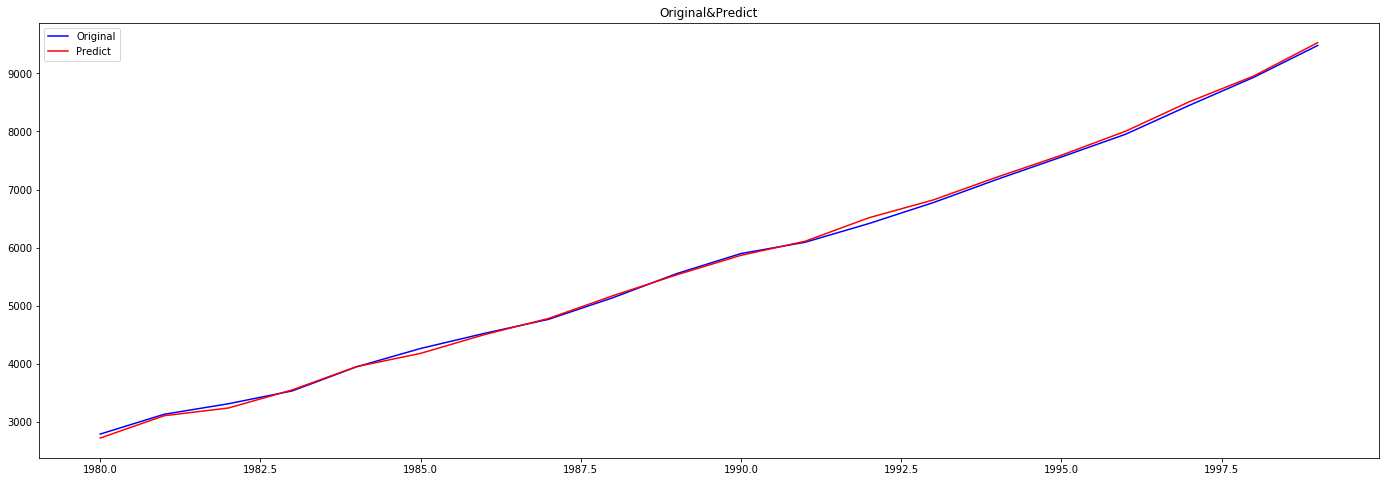

In [25]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(val, color='blue',label='Original')
predict = plt.plot(PREDICT_GDP[49:70], color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [26]:
val_mse = ((PREDICT_GDP[49:70]-val)**2).mean()
val_mse

2266.2690877194045

Calculate the predicted residual rate, and draw the residual rate scatter plot and distribution histogram. It can be seen that most of the absolute values ​​are within 5%, and the more backward, the smaller the error. It shows that the model is still accurate.

/Users/tamsin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tamsin/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


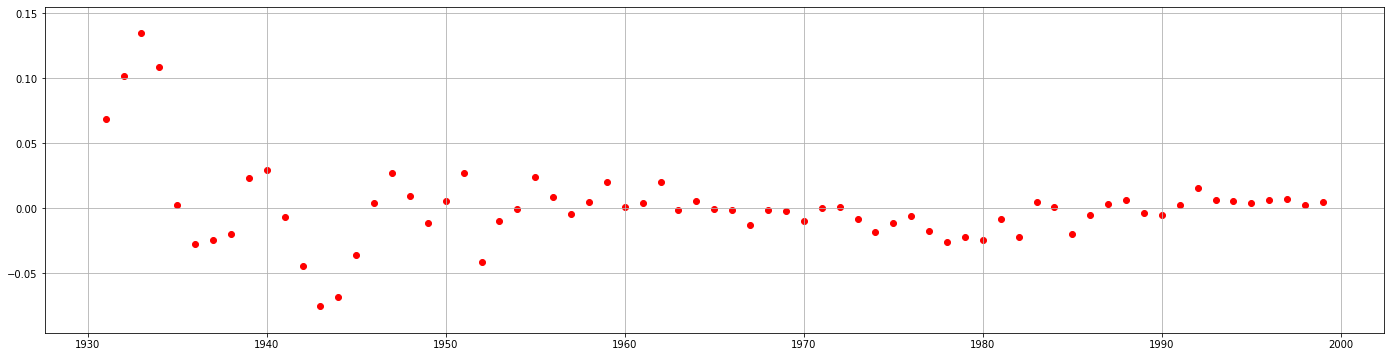

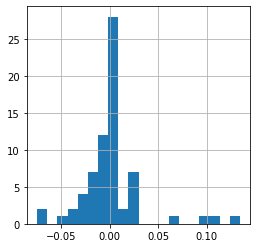

In [28]:
ERROR_RATE=(PREDICT_GDP-fygdp)/fygdp
plt.figure(figsize=(24, 6))   
plt.scatter(ERROR_RATE.index,ERROR_RATE,color='r')
plt.grid(True)
plt.figure(figsize=(4, 4))
plt.hist(ERROR_RATE, bins=20)
plt.grid(True)
plt.show()

Accuracy of test set:

In [35]:
PREDICT_ARMA_test = MODEL20.predict(start=69,end=89)
PREDICT_ARMA_test.index=PREDICT_ARMA_test.index+1930

/Users/tamsin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


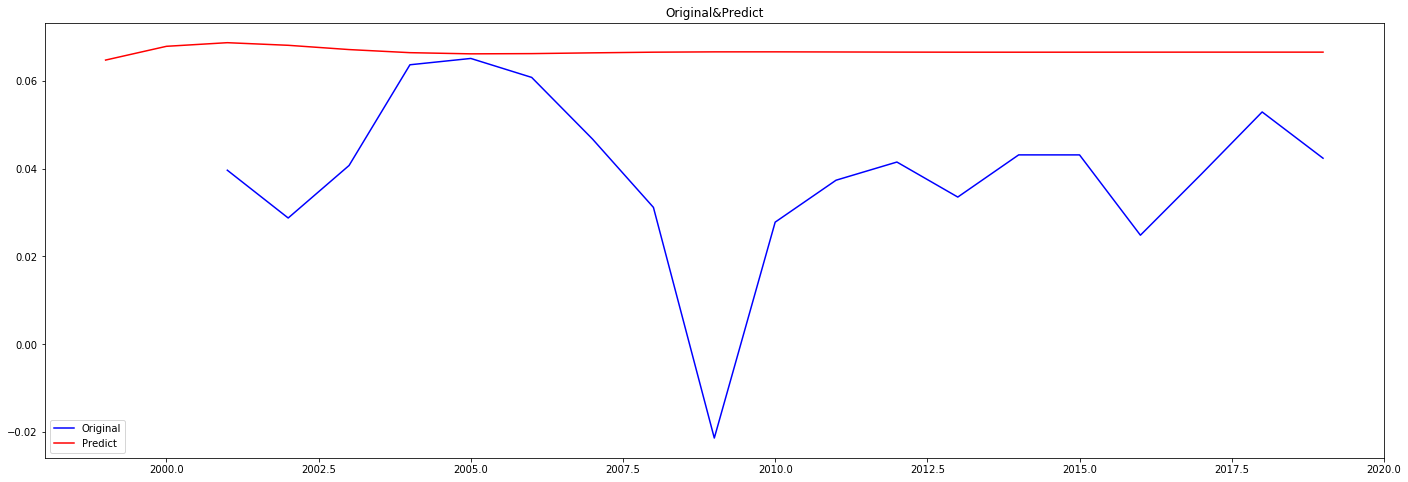

In [36]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(np.log(test).diff(1), color='blue',label='Original')
predict = plt.plot(PREDICT_ARMA_test, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [37]:
PREDICT1_ARMA = MODEL20.predict(start=70,end=89)
PREDICT1_ARMA.index=PREDICT1_ARMA.index+1930

/Users/tamsin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [38]:
log_gdp_test=np.log(test)
PREDICT_GDP_LOG_test = PREDICT1_ARMA.add(log_gdp_test.shift(1))
PREDICT_GDP_LOG_test[2019]=PREDICT1_ARMA[2019]+log_gdp_test[2018]
PREDICT_GDP_test = np.exp(PREDICT_GDP_LOG_test)
PREDICT_GDP_test.dropna(inplace=True)
PREDICT_GDP_test

2001    10836.709480
2002    11268.190414
2003    11585.658353
2004    12058.593701
2005    12847.681313
2006    13712.505183
2007    14574.277227
2008    15273.751062
2009    15758.517436
2010    15425.632653
2011    15860.204979
2012    16463.482828
2013    17160.783037
2014    17745.764249
2015    18527.972367
2016    19344.636779
2017    19831.230281
2018    20614.470351
2019    21734.449780
dtype: float64

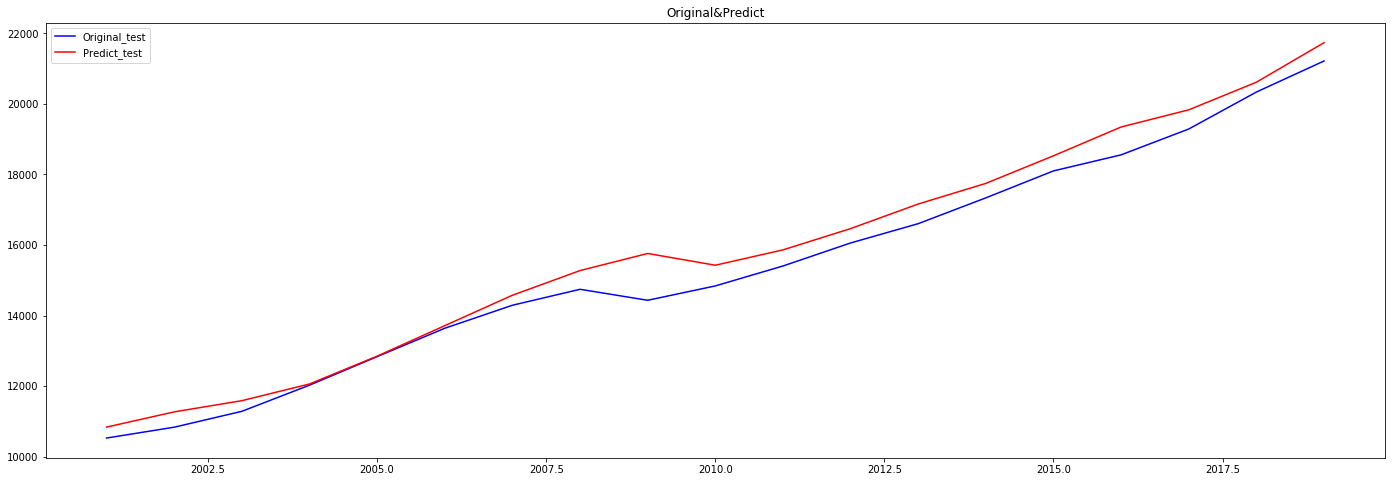

In [40]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(test[1:], color='blue',label='Original_test')
predict = plt.plot(PREDICT_GDP_test, color='red',label='Predict_test')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [41]:
predict_val=PREDICT_GDP[49:69]

In [42]:
mse_val=((predict_val-val)**2).mean()

In [43]:
mse_val

2266.2690877194045

In [44]:
predict_test=PREDICT_GDP_test

In [45]:
mse_test=((predict_test-test[1:])**2).mean()

In [46]:
mse_test

271140.23576364556